<h1 align="center">Data Science - Final Project</h1>
<p align="center">
  <a href="https://github.com/cuong091200">
    <img src="https://img.shields.io/badge/18120296-cuong091200-brightgreen.svg">
  </a>
  <a href="https://github.com/viplazylmht">
    <img src="https://img.shields.io/badge/18120339-viplazylmht-brightgreen.svg">
  </a>
  <a href="https://colab.research.google.com/github/cuong091200/DoAnCuoiKy_KHDL/blob/main/ProjectFinal.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg">
  </a>

  <a href="https://github.com/cuong091200/DoAnCuoiKy_KHDL">
    <img src="https://img.shields.io/badge/Github-131313?logo=github&logoColor=white">
  </a>
</p>

<p align="center">Danh sách thành viên</p>

|MSSV|Họ và Tên
|:---|:-
|18120296|Cao Tất Cường
|18120339|Hà Văn Duy

 

## Tổng quan

**COVID-19**

Đây là đại dịch bệnh tryền nhiễm nguy hiểm, phát hiện lần đầu tiên ở Trung Quốc sau đó nhanh chóng lan rộng ra toàn thế giới.  
Người mắc phải virus gây bệnh (SARS-CoV-2) thường sẽ có một khoảng thời gian ủ bệnh từ **2 - 14 ngày**, sau đó xuất hiện triệu chứng, một vài trường hợp có thể diễn tiến rất nhanh trở thành ca bệnh nặng, có thể dẫn đến tử vong.

Thời điểm hiện tại, vacxin vẫn chưa được phân phối rộng rãi và kiểm định kết quả, đồng thời vẫn chưa có thuốc chữa đặc hiệu. Vì vậy, các bệnh nhân cần được chăm sóc y tế hồi sức để cơ thể tự sản sinh ra đề kháng và khỏi bệnh.  
Đây là một dịch bệnh nghiêm trọng, vì vậy việc theo dõi sự tác động của nó với xã hội là điều cực kì cần thiết nhằm đưa ra các chính sách, giải pháp phù hợp để cải thiện tình hình, tiến tới xóa bỏ đại dịch trong tương lai gần.



## Cài đặt và import các thư viện cần thiết

In [1]:
# handle output to /dev/null to ignore text outputs xD
!pip install sodapy > /dev/null

# update sklearn to support set_config attr (see this answer: https://stackoverflow.com/a/62481510)
!pip install --upgrade scikit-learn > /dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVR
from sklearn import set_config
set_config(display='diagram')

from sodapy import Socrata

import regex as re
from sklearn.metrics import r2_score

## Thu thập dữ liệu


Nguồn cấp dữ liệu: <a href="https://cdc.gov">CDC</a> thông qua API.

<img style="vertical-align:middle" src="https://raw.githubusercontent.com/cuong091200/DoAnCuoiKy_KHDL/main/cdc_logo.svg"></img>

Theo mô tả của API, bộ dữ liệu này chứa danh sách các thông tin bao gồm số ca mắc và số ca tử vong mỗi ngày của các bang tại Mỹ. Cụ thể hơn, mỗi dòng dữ liệu là số liệu thống kê của một ngày của mỗi bang.  

---

Ta thu thập dữ liệu về và lưu vào `data_df`.

In [3]:
client = Socrata("data.cdc.gov", None)
 
results = client.get("9mfq-cb36", limit=30000)
 
data_df = pd.json_normalize(results)

## Khám phá dữ liệu (đủ để có thể xác định câu hỏi)

In [4]:
data_df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,2020-05-04T00:00:00.000,KY,5245,5245.0,0,115.0,0,261,261.0,0,8.0,0,2020-05-05T17:25:08.000,Agree,Agree
1,2020-12-08T00:00:00.000,OK,205999,171497.0,34502,0.0,0,1752,1680.0,72,0.0,0,2020-12-09T14:45:40.234,Agree,Agree
2,2020-04-30T00:00:00.000,IA,7145,NaN,NaN,302.0,0,162,NaN,NaN,14.0,0,2020-05-01T21:00:19.025,Not agree,Not agree
3,2020-06-25T00:00:00.000,NE,18346,NaN,NaN,125.0,0,260,NaN,NaN,3.0,0,2020-06-26T19:18:27.809,Not agree,Not agree
4,2020-02-24T00:00:00.000,CA,10,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Not agree,Not agree


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [5]:
data_df.shape

(20640, 15)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa các thông tin về số tổng ca nhiễm, số ca nhiễm mới, sô ca tử vong,... của của 1 bang trong một ngày cụ thể.

### Dữ liệu có các dòng bị lặp không?

In [6]:
data_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

|VARIABLE|DESCRIPTION|TYPE|
|---|----------------|------|
|submission_date|Date of counts|Date & Time|      
|state|Jurisdiction|Plain Text|  
|tot_cases|Total number of cases|Number| 
|conf_cases|Total confirmed cases|Number|
|prob_cases|Total probable cases|Number|
|new_case|Number of new cases|Number|
|pnew_case|Number of new probable cases|Number|
|tot_death|Total number of deaths|Number|
|conf_death|Total number of confirmed deaths|Number|
|prob_death|Total number of probable deaths|Number|
|new_death|Number of new deaths|Number|
|pnew_death|Number of new probable deaths|Number|
|created_at|Date and time record was created|Date & Time|
|consent_cases|If Agree, then confirmed and probable cases are included. If Not Agree, then only total cases are included|Plain Text|
|consent_deaths|If Agree, then confirmed and probable deaths are included. If Not Agree, then only total deaths are included|Plain Text|


	


	


	


	




## Đưa ra câu hỏi cần trả lời

Số ca mắc mới trong một ngày bất kì (hợp lệ) là bao nhiêu? Nó phụ thuộc như thế nào vào số ca mắc của những ngày trước đó?



### Ý nghĩa của việc trả lời câu hỏi trên

- Ta sẽ thấy được sự phụ thuộc của số ca mắc mới trong một ngày với số ca mắc của những ngày trước đó.
- Thấy được khả năng và tần suất lây lan của dịch bệnh trên người.
- Đưa ra dự đoán trong tương lai gần nhằm giúp chính phủ và ngành Y tế có thể tăng khả năng y tế dự phòng và triển khai các biện pháp ứng phó phù hợp với tình hình.
- Ước lượng được các làn sóng dịch tiếp theo trong một khu vực.


### Cảm hứng đặt câu hỏi

Cảm hứng để nhóm đặt câu hỏi này bắt nguồn từ thực trạng hiện nay, khi mà diễn biến dịch bệnh vẫn đang rất phức tạp tại nhiều quốc gia trên thế giới, đồng thời với tấm gương sự hành động cứng rắn của chính phủ Việt Nam dựa trên số liệu giúp đạt được kết quả phòng chống dịch tốt như hiện tại.

## Tiền xử lý dữ liệu để phù hợp với bài toán

### Thêm thuộc tính cho mỗi dòng dữ liệu

Bộ dữ liệu thô phía trên chưa có sự kết nối giữa những ngày liền kề nhau. Vì vậy ta sẽ tiền xử lý một chút để, đối với mỗi dòng dữ liệu, nó sẽ chứa thêm thông tin của số ca mắc mới của `callback_days` ngày liền trước đó. 

Hàm `add_row_df` sẽ làm nhiệm vụ trên: số ca mắc của `i` ngày trước của mỗi dòng dữ liệu sẽ được thêm vào cột `new_case_his_i`. 

In [7]:
# number of records will be collected
callback_days = 28

def add_row_df(df):
    df = df.sort_values('submission_date', ascending=True)

    # Validation raw data
    for g in df.groupby('submission_date'):
        if g[1].shape[0] > 1:
            raise Exception("Error, please groupby dataset by date before pass to this func")
    
    # MAGIC
    new_case_data = df['new_case']
    
    l = None

    for j in range(len(new_case_data)):
        if j >= callback_days:
            t = new_case_data.iloc[j - callback_days: j]
            
            # append row
            l = np.r_[l, [np.flip(t)]]
        else:
            t = new_case_data.iloc[0: j + 1]
            fill = np.r_[np.array(['0' for i in range(callback_days - len(t))]), t]

            # append row
            if l is None:
                l = np.array([np.flip(fill)])
            else:
                l = np.r_[l, [np.flip(fill)]]
    
    df2 = pd.DataFrame(l, index=df.index, columns=[f"new_case_his_{i}" for i in range(1, callback_days + 1)])
    
    return pd.concat([df, df2], axis=1)

In [8]:
whitelist = ['submission_date', 'state', 'created_at','consent_cases','consent_deaths']
usa_collected_df = add_row_df(data_df.transform(lambda x: x if (x.name in whitelist) else pd.to_numeric(x, errors='coerce')).groupby('submission_date').sum())
usa_collected_df = usa_collected_df.transform(lambda x: x if (x.name in whitelist) else pd.to_numeric(x, errors='coerce'))

In [9]:
usa_collected_df.tail()

,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,...,new_case_his_19,new_case_his_20,new_case_his_21,new_case_his_22,new_case_his_23,new_case_his_24,new_case_his_25,new_case_his_26,new_case_his_27,new_case_his_28
submission_date,,,,,,,,,,,,,,,,,,,,,
2020-12-26T00:00:00.000,18909910,8666714.0,888223.0,179104.0,12912.0,330901,181604.0,19347.0,1309.0,127.0,...,186815.0,176194.0,209445.0,217196.0,222300.0,199025.0,180796.0,152909.0,153454.0,143634.0
2020-12-27T00:00:00.000,19055869,8712179.0,896065.0,145959.0,14704.0,332246,182188.0,19417.0,1345.0,228.0,...,222606.0,186815.0,176194.0,209445.0,217196.0,222300.0,199025.0,180796.0,152909.0,153454.0
2020-12-28T00:00:00.000,19232843,8793726.0,908269.0,176974.0,17620.0,334029,183189.0,19575.0,1783.0,252.0,...,233824.0,222606.0,186815.0,176194.0,209445.0,217196.0,222300.0,199025.0,180796.0,152909.0
2020-12-29T00:00:00.000,19433639,8857372.0,931940.0,200796.0,37394.0,337435,184795.0,19853.0,3406.0,292.0,...,206066.0,233824.0,222606.0,186815.0,176194.0,209445.0,217196.0,222300.0,199025.0,180796.0
2020-12-30T00:00:00.000,19663976,8946883.0,959423.0,230337.0,41729.0,341199,186390.0,20184.0,3764.0,323.0,...,246716.0,206066.0,233824.0,222606.0,186815.0,176194.0,209445.0,217196.0,222300.0,199025.0


In [10]:
usa_X_df = usa_collected_df.drop('new_case', axis=1)
usa_y_sr = usa_collected_df['new_case']

Ta sẽ áp dụng phương pháp trên đối với mỗi bang (bằng cách gom nhóm), nhằm đảm bảo dữ liệu nhất quán và chính xác. Kết quả bộ dữ liệu mới sẽ được lưu vào `collected_df`.

In [11]:
collected_df = data_df.groupby('state').apply(add_row_df).reset_index(level='state', drop=True)

In [12]:
# incorrect? test this cell
#collected_df.groupby('state').get_group('AK').sort_values('submission_date', ascending=True).tail(10) 

### Ép về đúng kiểu dữ liệu

Ta sẽ ép về dữ liệu số đối với các cột có kiểu là số.

In [13]:
whitelist = ['submission_date', 'state', 'created_at','consent_cases','consent_deaths']

collected_df = collected_df.transform(lambda x: x if (x.name in whitelist) else pd.to_numeric(x, errors='coerce'))

### Loại bỏ các dòng dữ liệu chắc chắn là nhiễu

Một dòng được coi là dữ liệu nhiễu khi cho tới ngày đó chưa ghi nhận ca mắc nào (`tot_cases = 0`).

Ngoài ra, nhóm còn quy định dòng dữ liệu có thông số `new_case` âm là nhiễu.

In [14]:
collected_df = collected_df[(collected_df['tot_cases'] > 0) & (collected_df['new_case'] > 0)]
collected_df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,...,new_case_his_19,new_case_his_20,new_case_his_21,new_case_his_22,new_case_his_23,new_case_his_24,new_case_his_25,new_case_his_26,new_case_his_27,new_case_his_28
8286,2020-03-13T00:00:00.000,AK,1,NaN,NaN,1.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18091,2020-03-17T00:00:00.000,AK,3,NaN,NaN,2.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17969,2020-03-18T00:00:00.000,AK,6,NaN,NaN,3.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19972,2020-03-19T00:00:00.000,AK,9,NaN,NaN,3.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19368,2020-03-20T00:00:00.000,AK,12,NaN,NaN,3.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
collected_df.shape

(15285, 43)

Đến đây, từ dữ liệu thô, ta đã thu thập đủ dữ liệu (được lưu trong `collected_df`) để có thể khai thác để trả lời câu hỏi.

## Tiền xử lý (tách tập)

Input của bài toán sẽ bao gồm một số cột trong dữ liệu. Output chính là cột `new_case`. 

In [16]:
sorted_df = collected_df.sort_values('submission_date', ascending=True)
X_df = sorted_df.drop('new_case', axis=1)
y_sr = sorted_df['new_case']

Tách theo tỉ lệ: 80% 10% 10% lần lượt cho bộ train, bộ validation, bộ test.

In [17]:
# tách bộ (train, validation) và bộ test

new_X_df, test_X_df, new_y_sr, test_y_sr = train_test_split(X_df, y_sr, train_size = 0.9, 
                                                             shuffle=False, random_state=0)

Tách bộ tran và bộ validation.

In [18]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(new_X_df, new_y_sr, train_size=(8/9), 
                                                              random_state=0)

In [19]:
train_X_df.shape

(12227, 42)

## Khám phá dữ liệu (tập huấn luyện)

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [20]:
train_X_df.dtypes

submission_date     object
state               object
tot_cases            int64
conf_cases         float64
prob_cases         float64
pnew_case          float64
tot_death            int64
conf_death         float64
prob_death         float64
new_death          float64
pnew_death         float64
created_at          object
consent_cases       object
consent_deaths      object
new_case_his_1     float64
new_case_his_2     float64
new_case_his_3     float64
new_case_his_4     float64
new_case_his_5     float64
new_case_his_6     float64
new_case_his_7     float64
new_case_his_8     float64
new_case_his_9     float64
new_case_his_10    float64
new_case_his_11    float64
new_case_his_12    float64
new_case_his_13    float64
new_case_his_14    float64
new_case_his_15    float64
new_case_his_16    float64
new_case_his_17    float64
new_case_his_18    float64
new_case_his_19    float64
new_case_his_20    float64
new_case_his_21    float64
new_case_his_22    float64
new_case_his_23    float64
n

TODO: NHẬN XÉT

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [21]:
num_cols = list(set(train_X_df.columns) - set(whitelist))
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,new_case_his_20,conf_death,new_case_his_19,new_case_his_14,new_case_his_2,new_case_his_23,new_case_his_9,new_case_his_11,new_case_his_7,new_case_his_5,...,new_case_his_22,prob_cases,new_case_his_27,new_case_his_12,tot_death,new_case_his_1,new_case_his_25,new_case_his_28,new_case_his_18,conf_cases
missing_ratio,0.0,49.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,52.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.9
min,-33355.0,0.0,-33355.0,-33355.0,-30134.0,-33355.0,-33355.0,-33355.0,-33355.0,-33355.0,...,-33355.0,0.0,-4755.0,-33355.0,0.0,-33355.0,-10427.0,-10427.0,-33355.0,1.0
lower_quartile,34.0,401.0,36.0,52.0,71.0,29.0,56.0,49.0,67.0,63.0,...,30.0,93.5,23.0,49.0,105.0,71.0,25.0,26.0,35.5,11127.0
median,280.0,1517.0,288.0,318.0,369.0,269.0,332.0,321.0,356.0,354.0,...,270.0,1470.0,250.0,319.0,681.0,365.0,262.0,255.0,290.0,45392.0
upper_quartile,817.0,3728.0,841.5,897.5,1001.0,807.5,938.0,917.5,971.0,986.0,...,804.0,5493.0,763.0,912.0,2994.5,1008.0,785.5,776.0,847.0,121411.5
max,71734.0,19603.0,71734.0,49458.0,71734.0,71734.0,71734.0,49458.0,71734.0,71734.0,...,71734.0,49430.0,71734.0,71734.0,24297.0,71734.0,71734.0,71734.0,71734.0,738846.0


TODO: NHẬN XÉT

Ta thấy những thuộc tính pnew_case, new_death

### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [22]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(train_X_df.columns) - set(num_cols))
df = train_X_df[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,submission_date,state,consent_deaths,created_at,consent_cases
missing_ratio,0,0,4.9,0,4.9
num_values,287,58,3,456,3
value_ratios,"{'2020-04-11T00:00:00.000': 0.4, '2020-09-30T00:00:00.000': 0.4, '2020-04-04T00:00:00.000': 0.4, '2020-08-13T00:00:00.000': 0.4, '2020-04-09T00:00:00.000': 0.4, '2020-04-23T00:00:00.000': 0.4, '20...","{'NY': 2.1, 'MA': 2.0, 'CA': 2.0, 'PA': 2.0, 'IN': 2.0, 'WI': 2.0, 'NJ': 2.0, 'OR': 2.0, 'IA': 2.0, 'NV': 2.0, 'IL': 1.9, 'CO': 1.9, 'NE': 1.9, 'NM': 1.9, 'AR': 1.9, 'GA': 1.9, 'OH': 1.9, 'NC': 1....","{'Agree': 62.2, 'Not agree': 31.2, 'N/A': 6.6}","{'2020-03-26T16:22:39.452': 6.4, '2020-05-25T15:38:40.000': 1.8, '2020-11-13T19:10:12.893': 1.6, '2020-03-28T16:22:39.452': 0.8, '2020-04-03T16:22:39.452': 0.8, '2020-04-07T16:22:39.452': 0.7, '20...","{'Agree': 57.6, 'Not agree': 30.9, 'N/A': 11.5}"


TODO: NHẬN XÉT

## Tiền xử lý tập huấn luyện

- Loại bỏ các thuộc tính dự đoán như `pnew_case`, `pnew_death`
- Loại bỏ các thuộc tính không có ích cho việc huấn luyện mô hình như `submission_date`, `state`, `conf_death`, `prob_death`, `created_at`, `consent_cases`, `consent_deaths`

- Dùng tham số `callback_days` để quy định chỉ lấy số ngày gần nhất của ngày hiện tại.

- Hàm `mix_data` dùng để fill lại các giá trị của cột `conf_cases` bằng giá trị tương ứng của cột `tot_cases` nếu nó bị thiếu.



In [23]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, callback_days=14):
        self.callback_days = callback_days

    def fit(self, X_df, y=None):
        return self
    
    def mix_data(self, row):
        tot_cases = row.loc['tot_cases']
        if row.isnull().loc['conf_cases']:
            row.loc['conf_cases'] = tot_cases            

        return row

    def transform(self, X_df, y=None):

        # drop unsue attr
        df = X_df.drop(['pnew_case', 'pnew_death', 'submission_date', 'state', 'conf_death', 'prob_death', 'created_at',
                        'consent_cases', 'consent_deaths'], axis=1, errors = 'ignore')

        # regex to match first number in any text
        matcher = re.compile(r'.*?(\d+)')
        
        columns_sr = df.columns.str.extract(r'(.*?\d+)', expand=False).dropna().to_series()
        list_drop_his = columns_sr.transform(lambda x: x if int(matcher.findall(x)[0]) > self.callback_days else np.nan).dropna().values.tolist()
        if len(list_drop_his) > 0:
            df = df.drop(list_drop_his, axis=1)
            
        df['total_new_case_his'] = df.iloc[:, 5:].sum(axis=1)
        df = df.drop(df.columns[5:-1],axis=1)

        return df.transform(self.mix_data, axis=1)


In [24]:
estimator = ColDropper(callback_days=5)
estimator.fit(train_X_df)

ColDropper(callback_days=5)

In [25]:
# estimator.transform(train_X_df).duplicated(keep='last').sum()
# 262 (if callback_days = 20) How?

In [26]:
# TEST
tmp = estimator.transform(train_X_df)
tmp

,tot_cases,conf_cases,prob_cases,tot_death,new_death,total_new_case_his
7851,8317.0,8317.0,NaN,441.0,2.0,181.0
15942,18646.0,18532.0,114.0,310.0,5.0,1707.0
6231,220214.0,215598.0,4616.0,23278.0,11.0,1425.0
13820,9090.0,9090.0,0.0,409.0,35.0,1212.0
12557,704085.0,704085.0,NaN,12933.0,28.0,26814.0
...,...,...,...,...,...,...
13691,1140861.0,1140861.0,NaN,19883.0,187.0,54222.0
17013,32005.0,31988.0,17.0,1442.0,38.0,3350.0
6392,36093.0,33154.0,2939.0,429.0,6.0,1193.0
5144,47807.0,47807.0,NaN,501.0,4.0,2825.0


### Xây dựng pipeline



Các thuộc tính sẽ được fill bằng `mean` nhằm đảm bảo không còn nơi nào bị thiếu dữ liệu kể cả trên bộ test mới.

## Tiền xử lý + mô hình hóa

### Tìm mô hình tốt nhất

#### Thử nhiệm 1: Mô hình MLP

In [27]:
pipe_line = make_pipeline(ColDropper(), SimpleImputer(strategy='mean'),
            StandardScaler(),
            MLPRegressor(hidden_layer_sizes=(30,), activation='relu', solver='adam', max_iter=3000, random_state=0))

In [28]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
callback_days_s = [6, 8, 10, 12, 14, 16]
best_val_err = float('inf'); best_alpha = None; best_callback_days = None
for alpha in alphas:
    for callback_days in callback_days_s:
        
        print(f"Processing alpha={alpha}\tcallback_days={callback_days}...", end="\t")
        pipe_line.set_params(coldropper__callback_days=callback_days, mlpregressor__alpha=alpha)

        pipe_line.fit(train_X_df, train_y_sr)
        
        train_err = (1 - r2_score(train_y_sr, pipe_line.predict(train_X_df))) * 100
        val_err = (1 - r2_score(val_y_sr, pipe_line.predict(val_X_df))) * 100
        
        train_errs.append(train_err)
        val_errs.append(val_err)
        
        if val_err < best_val_err:
            best_val_err = val_err 
            best_alpha = alpha
            best_callback_days = callback_days        

        print(f"train_err: {train_err}\t val_err: {val_err}")  
'Finish!'

Processing alpha=0.1	callback_days=6...	train_err: 25.938830961422553	 val_err: 15.71479767806231
Processing alpha=0.1	callback_days=8...	train_err: 25.814516898913375	 val_err: 15.549447331741707
Processing alpha=0.1	callback_days=10...	train_err: 26.23553390349953	 val_err: 16.907540566472555
Processing alpha=0.1	callback_days=12...	train_err: 26.62551509050011	 val_err: 16.976444019127236
Processing alpha=0.1	callback_days=14...	train_err: 26.11619234789664	 val_err: 18.760989746527613
Processing alpha=0.1	callback_days=16...	train_err: 26.840387410574284	 val_err: 19.78946530523039
Processing alpha=1	callback_days=6...	train_err: 25.92664153406188	 val_err: 15.73486165360023
Processing alpha=1	callback_days=8...	train_err: 25.815578117100245	 val_err: 15.548397510842104
Processing alpha=1	callback_days=10...	train_err: 26.23535252807678	 val_err: 16.90712384240073
Processing alpha=1	callback_days=12...	train_err: 26.62584657132625	 val_err: 16.977093684857092
Processing alpha=1	cal

'Finish!'

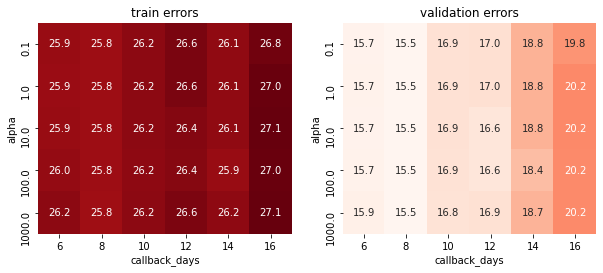

In [29]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=callback_days_s)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=callback_days_s)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('callback_days'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('callback_days'); plt.ylabel('alpha');

In [30]:
pipe_line.set_params(coldropper__callback_days=best_callback_days, mlpregressor__alpha=best_alpha)
 
pipe_line.fit(pd.concat([train_X_df, val_X_df]), pd.concat([train_y_sr, val_y_sr]))
#pipe_line.fit(train_X_df, train_y_sr)

Pipeline(steps=[('coldropper', ColDropper(callback_days=8)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=1000, hidden_layer_sizes=(30,),
                              max_iter=3000, random_state=0))])

Đánh giá độ lỗi trên bộ test

In [31]:
(1 - r2_score(test_y_sr, pipe_line.predict(test_X_df))) * 100

13.90102002089668

Đánh giá độ lỗi trên bộ dữ liệu của cả nước Mỹ

In [32]:
(1 - r2_score(usa_y_sr, pipe_line.predict(usa_X_df))) * 100

4.699848055141831

#### Thử nhiệm 2: Mô hình Ridge (Linear)

In [33]:
pipe_line1 = make_pipeline(ColDropper(), SimpleImputer(strategy='mean'),
            StandardScaler(),
            Ridge())

In [34]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất

train_errs = []
val_errs = []
alphas = [0.1, 10, 1000]
callback_days_s = [8, 10, 12]
best_val_err1 = float('inf'); best_alpha1 = None; best_callback_days1 = None
for alpha in alphas:
    for callback_days in callback_days_s:
        
        print(f"Processing alpha={alpha}\tcallback_days={callback_days}...", end="\t")
        pipe_line1.set_params(coldropper__callback_days=callback_days, ridge__alpha=alpha)

        pipe_line1.fit(train_X_df, train_y_sr)
        
        train_err = (1 - r2_score(train_y_sr, pipe_line.predict(train_X_df))) * 100
        val_err = (1 - r2_score(val_y_sr, pipe_line.predict(val_X_df))) * 100
        
        train_errs.append(train_err)
        val_errs.append(val_err)
        
        if val_err < best_val_err1:
            best_val_err1 = val_err 
            best_alpha1 = alpha
            best_callback_days1 = callback_days        

        print(f"train_err: {train_err}\t val_err: {val_err}")  
'Finish!'

Processing alpha=0.1	callback_days=8...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=0.1	callback_days=10...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=0.1	callback_days=12...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=10	callback_days=8...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=10	callback_days=10...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=10	callback_days=12...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=1000	callback_days=8...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=1000	callback_days=10...	train_err: 25.78438684587887	 val_err: 15.319983666280901
Processing alpha=1000	callback_days=12...	train_err: 25.78438684587887	 val_err: 15.319983666280901


'Finish!'

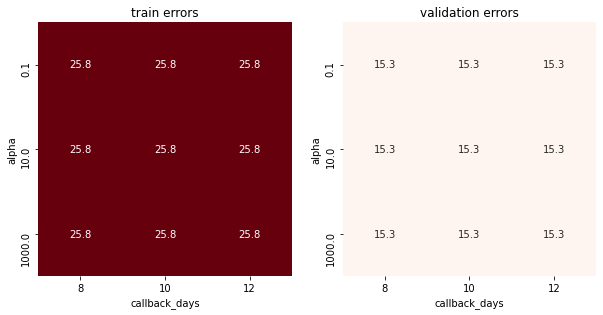

In [35]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=callback_days_s)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=callback_days_s)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('callback_days'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('callback_days'); plt.ylabel('alpha');

In [36]:
pipe_line1.set_params(coldropper__callback_days=best_callback_days1, ridge__alpha=best_alpha1)
 
pipe_line1.fit(pd.concat([train_X_df, val_X_df]), pd.concat([train_y_sr, val_y_sr]))

Pipeline(steps=[('coldropper', ColDropper(callback_days=8)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.1))])

Đánh giá độ lỗi trên bộ test

In [37]:
(1 - r2_score(test_y_sr, pipe_line1.predict(test_X_df))) * 100

13.95284297965469

Đánh giá độ lỗi trên bộ dữ liệu của cả nước Mỹ

In [38]:
(1 - r2_score(usa_y_sr, pipe_line1.predict(usa_X_df))) * 100

19.89224984040987

### Đánh giá mô hình tìm được

TODO: Chọn mô hình nào, giải thích

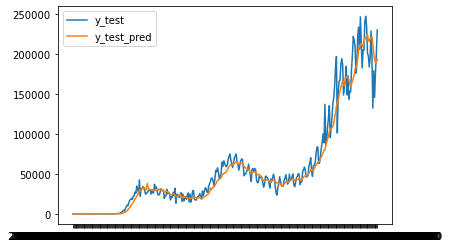

In [39]:
plt.plot(usa_y_sr)
plt.plot(pipe_line.predict(usa_X_df))
plt.legend(['y_test', 'y_test_pred'])

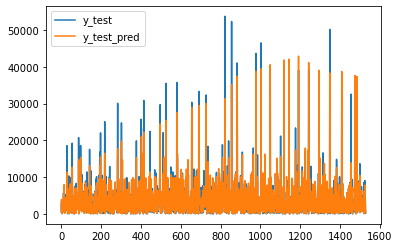

In [40]:
plt.plot(test_y_sr.reset_index(drop=True))
plt.plot(pipe_line.predict(test_X_df))
plt.legend(['y_test', 'y_test_pred'])